used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

# TO DO:


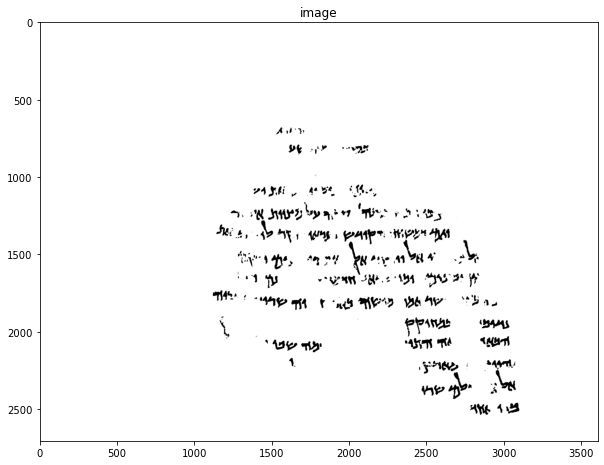

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np


easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'


image = cv2.imread(half_sentences_scroll, cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(10,10))
plt.axis()
plt.title("image")
plt.imshow(image, cmap="gray")
plt.show()

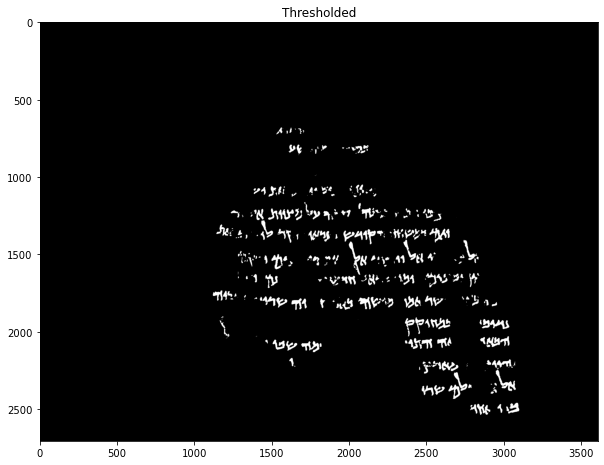

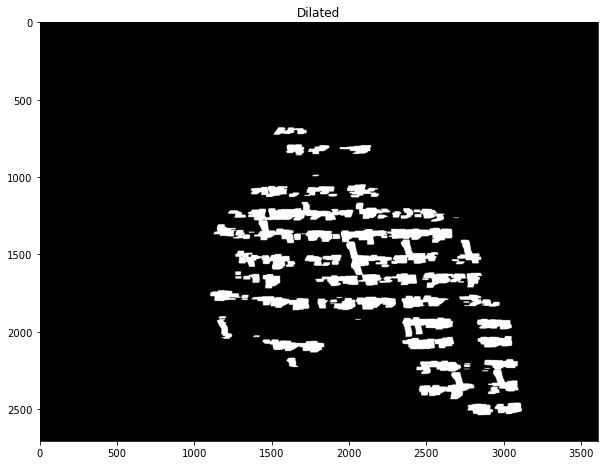

In [2]:
#maybe use this instead of the other gray image becaus here the small things are removed and we can find a better path i think.

def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
    plt.figure(figsize=(10,10))
    plt.title("Thresholded")
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(image)

#dilation
#We can change the dilation to create larger letters if we want to.first num is vertical, second num is horizontal dilation
#3,15 is the one used since the beginning, we can change to other settings if we like
kernel = np.ones((4,35), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

plt.figure(figsize=(10,10))
plt.title("Dilated")
plt.imshow(dilated, cmap='gray')
plt.show()

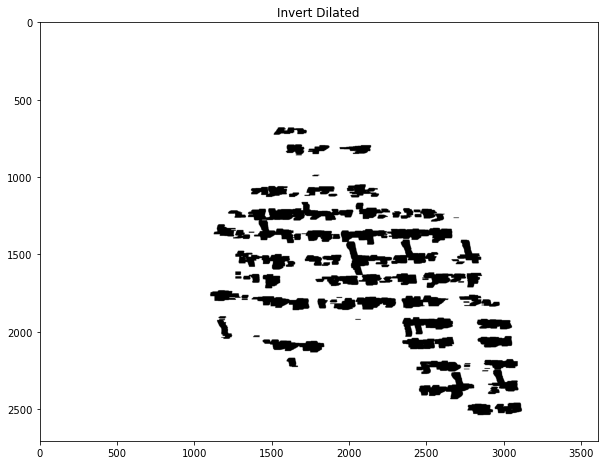

In [3]:
#Invert the image back from black background to white background, for the path finder. 
invert = cv2.bitwise_not(dilated)

plt.figure(figsize=(10,10))
plt.imshow(invert, cmap='gray')
plt.title("Invert Dilated")
plt.show()

img = invert

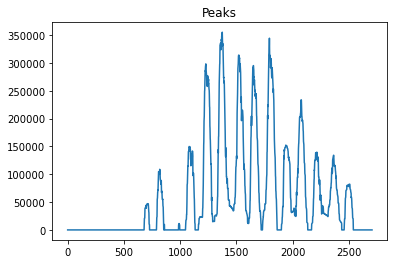

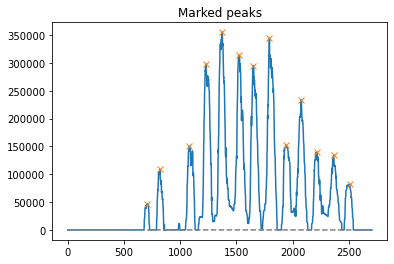

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def horizontal_projections(image):
    return np.sum(image, axis=1) 

hpp = horizontal_projections(dilated)
plt.plot(hpp)
plt.title("Peaks")
plt.show()


# The minimum_peak is just a treshold value for what number a peak minimum has to consist of. 
# The distance in the find_peaks() function seperates the peaks by a distance of minimum of 100. With the highest peak being selected. 
minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
peaks, _ = find_peaks(hpp, height=minimum_peak, distance=100)
plt.plot(hpp)
plt.title("Marked peaks")
plt.plot(peaks, hpp[peaks], "x")
plt.plot(np.zeros_like(hpp), "--", color="gray")
plt.show()

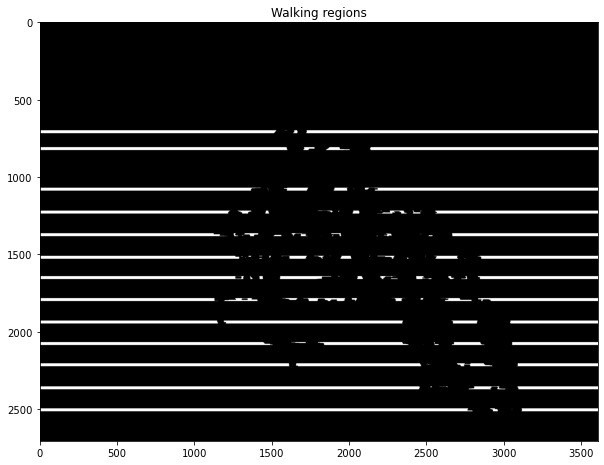

In [5]:
#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks

not_peaks = find_not_peak_regions(hpp)

not_peaks_index = np.array(not_peaks)[:,0].astype(int)


#Displays the image below
segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in not_peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(10,10))
plt.title("Walking regions")
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [6]:
#The Hpp_clusters is the black areas such that we have walking regions for the algorithm

#Create walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(not_peaks_index)

In [7]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    
    #print("start: " + str(start))
    #print("end: " + str(goal))
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit 
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 100 times the length of the input iterations
        if count > goal[1]*30:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [8]:
# #Copied from the github mentioned above
from skimage.filters import threshold_otsu

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

In [ ]:
#Segment all the lines using the A* algorithm
binary_image = get_binary(img)

line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    
    #The goal given is the middle of the walking region. But we adjusted in the path finder to the complete range.
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))
   
    #Finding a path is impossible, then just draw a straight line from begin to end
    if path.shape[0] == 0:
        line_new = []
        size_cluster = int(nmap.shape[0]/2)
        for i in range(nmap.shape[1] - 1):
            line_new.append([size_cluster, nmap.shape[1]-i -1])
            line = []
        line_new = np.asarray(line_new)
        offset_from_top = cluster_of_interest[0]
        line_new[:,0] += offset_from_top
        line_segments.append(line_new)
    else:
        offset_from_top = cluster_of_interest[0]
        path[:,0] += offset_from_top
        line_segments.append(path)

In [ ]:
#Print the created path throught the first inputted image
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,20), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis()
ax[0].axis()
ax[1].imshow(image, cmap="gray")
ax[0].imshow(image, cmap="gray")

In [ ]:
from PIL import Image

def white_array(height, width):
    image = np.zeros([height,width],dtype=np.uint8)
    image.fill(255)
    return image

In [ ]:
#Loop to create the seperate line images
line_count = len(line_segments)
line_image = []

for line_index in range(line_count-1):
    upper_bound = np.min(line_segments[line_index][:, 0])
    lower_bound = np.max(line_segments[line_index+1][:, 0])
    height = lower_bound - upper_bound
    width = image.shape[1]
    white_line_image = white_array(height, width)
    offset_top = upper_bound
    
    
    #Creates white areas around the sentences, such that bits and pieces of other sentences do not get in the line image
    for i in range(white_line_image.shape[0]):
        for j in range(white_line_image.shape[1] -1):
            if (line_segments[line_index][white_line_image.shape[1] - 2 - j][0] - i > upper_bound) or (i + offset_top > line_segments[line_index+1][white_line_image.shape[1] - 2 - j][0]) :              
                white_line_image[i][j] = 255     
            else:
                white_line_image[i][j] = image[upper_bound + i][j]

    line_image.append(white_line_image)
    
    plt.figure(figsize=(10,10))
    plt.imshow(white_line_image, cmap="gray")
    plt.show()

## Character segmentation

In [ ]:
test_image = line_image[6]

plt.figure(figsize=(10,10))
plt.imshow(test_image, cmap="gray")
plt.show()

In [ ]:
kernel = np.ones((20,30), np.uint8)
test_dilate = cv2.erode(test_image, kernel, iterations=1)

plt.figure(figsize=(15,15))
plt.imshow(test_dilate, cmap="gray")
plt.show()

In [ ]:
MINSIZE = 50
MAXSIZE = 2000


boxcoordinates = []
character_image = []

copy = test_image.copy()
thresholded = thresholding(test_dilate)

cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]


letters = []
for c in cnts:
    topleftx, toplefty, width, height = cv2.boundingRect(c)
    next_letter = [topleftx, toplefty, width, height]
    letters.append(next_letter)
    
letters = sorted(letters, reverse=True)
    

for letter in letters:
    topleftx, toplefty, width, height = letter
    
    #Reject contours that are too big or small to be likely letters
    if height<MINSIZE or width<MINSIZE:
        continue

    if height>MAXSIZE or width>MAXSIZE:
        continue
    
    
    cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
    boxcoordinates.append((topleftx, toplefty, width, height))
    
    character = test_image[toplefty:toplefty+height, topleftx:topleftx+width]
    plt.figure(figsize=(5,5))
    plt.imshow(character, cmap="gray")
    plt.show()
    character_image.append(character)
    
    
    
plt.figure(figsize=(20,20))
plt.imshow(copy, cmap="gray")
plt.show()